# Simulators


## Introduction

This notebook shows how to import the *Qiskit Aer* simulator backend and use it to run ideal (noise free) Qiskit Terra circuits.

In [19]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

## The Aer Provider
 
The `Aer` provider contains a variety of high performance simulator backends for a variety of simulation methods. The available backends on the current system can be viwed using `Aer.backends`

In [20]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

## The Aer Simulator
 
The main simulator backend of the Aer provider is the `AerSimulator` backend. A new simulator backend can be created using `Aer.get_backend('aer_simulator')`.

In [21]:
simulator = Aer.get_backend('aer_simulator')

The default behavior of teh `AerSimulator` backend is to mimic the execution of an actual device. If a `QuantumCircuit` containing measurements is run it will return a count dictionary containing the final values of any classical registers in the circuit. The circuit may contain gates, measurements, resets, conditionals, and other custom simulator instructions that will be discussed in another notebook.

### Simulating a quantum circuit

The basic operation runs a quantum circuit and returns a counts dictionary of measurement outcomes. Here we run a simple circuit that prepares a 2-qubit Bell-state $\left|\psi\right\rangle = \frac{1}{2}\left(\left|0,0\right\rangle + \left|1,1 \right\rangle\right)$ and measures both qubits.

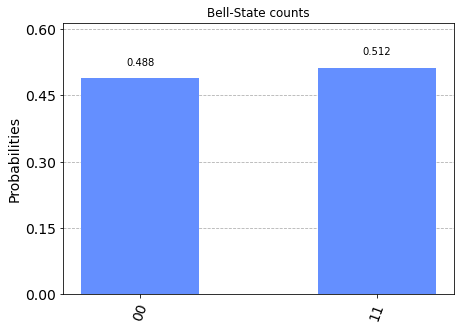

In [22]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

### Returning measurement outcomes for each shot

The `QasmSimulator` also supports returning a list of measurement outcomes for each individual shot. This is enabled by setting the keyword argument `memory=True` in the `run`.

In [6]:
# Run and get memory
result = simulator.run(circ, shots=10, memory=True).result()
memory = result.get_memory(circ)
print(memory)

['00', '11', '00', '00', '00', '11', '00', '11', '11', '00']


## Aer Simulator Options

The `AerSimulator` backend supports a variety of configurable options which can be updated using the `set_options` method. See the `AerSimulator` API documentation for additional details.

### Simulation Method

The `AerSimulator` supports a variety of simulation methods, each of which supports a different set of instructions. The method can be set manually using `simulator.set_option(method=value)` option, or a simulator backend with a preconfigured method can be obtained directly from the `Aer` provider using `Aer.get_backend`.

When simulating ideal circuits, changing the method between the exact simulation methods `stabilizer`, `statevector`, `density_matrix` and `matrix_product_state` should not change the simulation result (other than usual variations from sampling probabilities for measurement outcomes)

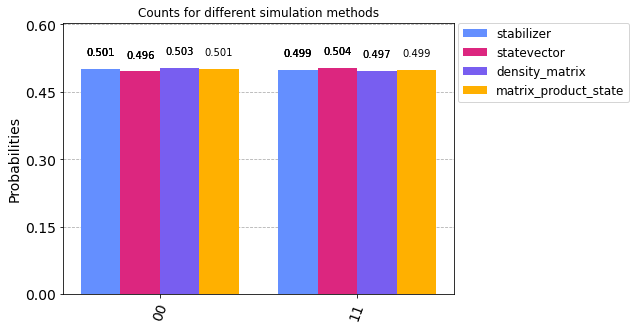

In [7]:
# Increase shots to reduce sampling variance
shots = 10000

# Stabilizer simulation method
sim_stabilizer = Aer.get_backend('aer_simulator_stabilizer')
job_stabilizer = sim_stabilizer.run(circ, shots=shots)
counts_stabilizer = job_stabilizer.result().get_counts(0)

# Statevector simulation method
sim_statevector = Aer.get_backend('aer_simulator_statevector')
job_statevector = sim_statevector.run(circ, shots=shots)
counts_statevector = job_statevector.result().get_counts(0)

# Density Matrix simulation method
sim_density = Aer.get_backend('aer_simulator_density_matrix')
job_density = sim_density.run(circ, shots=shots)
counts_density = job_density.result().get_counts(0)

# Matrix Product State simulation method
sim_mps = Aer.get_backend('aer_simulator_matrix_product_state')
job_mps = sim_mps.run(circ, shots=shots)
counts_mps = job_mps.result().get_counts(0)

plot_histogram([counts_stabilizer, counts_statevector, counts_density, counts_mps],
               title='Counts for different simulation methods',
               legend=['stabilizer', 'statevector',
                       'density_matrix', 'matrix_product_state'])

#### Automatic Simulation Method
The default simulation method is `automatic` which will automatically select a one of the other simulation methods for each circuit based on the instructions in those circuits. A fixed simualtion method can be specified by by adding the method name when getting the backend, or by setting the `method` option on the backend.

### GPU Simulation

The `statevector`, `density_matrix` and `unitary` simulators support running on a NVidia GPUs. For these methods the simulation device can also be manually set to CPU or GPU using `simulator.set_options(device='GPU')` backend option. If a GPU device is not available setting this option will raise an exception.

In [8]:
from qiskit.providers.aer import AerError

# Initialize a GPU backend
# Note that the cloud instance for tutorials does not have a GPU
# so this will raise an exception.
try:
    simulator_gpu = Aer.get_backend('aer_simulator')
    simulator_gpu.set_options(device='GPU')
except AerError as e:
    print(e)

"Invalid simulation device GPU. Available devices are: ['CPU']"


The `Aer` provider will also contain preconfigured GPU simulator backends if Qiskit Aer was installed with GPU support on a complatible system:

* `aer_simulator_statevector_gpu`
* `aer_simulator_density_matrix_gpu`
* `aer_simulator_unitary_gpu`

*Note: The GPU version of Aer can be installed using `pip install qiskit-aer-gpu`.*

### Simulation Precision

One of the available simulator options allows setting the float precision for the `statevector`, `density_matrix` `unitary` and `superop` methods.  This is done using the `set_precision="single"` or `precision="double"` (default) option:

In [9]:
# Configure a single-precision statevector simulator backend
simulator = Aer.get_backend('aer_simulator_statevector')
simulator.set_options(precision='single')

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
print(counts)

{'00': 512, '11': 512}


Setting the simulation precesion applies to both CPU and GPU simulation devices. Single precision will halve the requried memeory and may provide performance improvements on certain systems.

## Custom Simulator Instructions

### Saving the simulator state

The state of the simulator can be saved in a variety of formats using custom simulator instructions.


| Circuit method | Description |Supported Methods | 
|----------------|-------------|------------------|
| `save_state` | Save the simulator state in the native format for the simulation method | All | 
| `save_statevector` | Save the simulator state as a statevector | `"automatic"`, `"statevector"`, `"matrix_product_state"`, `"extended_stabilizer"`|
| `save_stabilizer` | Save the simulator state as a Clifford stabilizer | `"automatic"`, `"stabilizer"`| 
| `save_density_matrix` | Save the simulator state as a density matrix | `"automatic"`, `"statevector"`, `"matrix_product_state"`, `"density_matrix"` |
| `save_matrix_product_state` | Save the simulator state as a a matrix product state tensor | `"automatic"`, `"matrix_product_state"`|
| `save_unitary` | Save the simulator state as unitary matrix of the run circuit | `"automatic"`, `"unitary"`|
| `save_superop` | Save the simulator state as superoperator matrix of the run circuit | `"automatic"`, `"superop"`|

Note that these instructions are only supported by the Aer simulator and will result in an error if a circuit containing them is run on a non-simulator backend such as an IBM Quantum device.

#### Saving the final statevector

To save the final statevector of the simulation we can append the circuit with the `save_statevector` instruction. Note that this instruction should be applied *before* any measurements if we do not want to save the collapsed post-measurement state

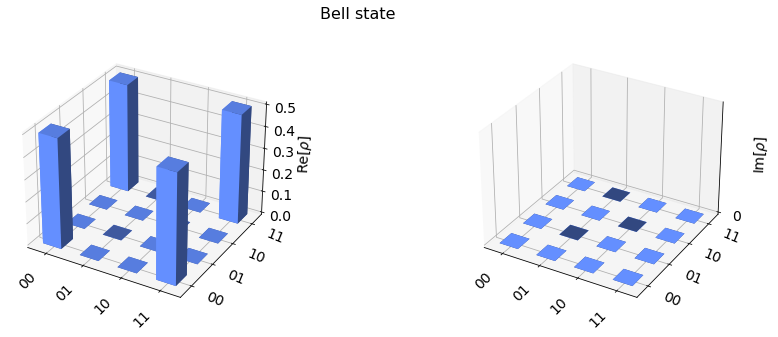

In [10]:
# Construct quantum circuit without measure
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.save_statevector()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get statevector
result = simulator.run(circ).result()
statevector = result.get_statevector(circ)
plot_state_city(statevector, title='Bell state')

#### Saving the circuit unitary

To save the unitary matrix for a `QuantumCircuit` we can append the circuit with the `save_unitary` instruction. Note that this circuit cannot contain any measurements or resets since these instructions are not suppored on for the `"unitary"` simulation method

In [11]:
# Construct quantum circuit without measure
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.save_unitary()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get unitary
result = simulator.run(circ).result()
unitary = result.get_unitary(circ)
print("Circuit unitary:\n", unitary.round(5))

Circuit unitary:
 [[ 0.70711+0.j  0.70711-0.j  0.     +0.j  0.     +0.j]
 [ 0.     +0.j  0.     +0.j  0.70711+0.j -0.70711+0.j]
 [ 0.     +0.j  0.     +0.j  0.70711+0.j  0.70711-0.j]
 [ 0.70711+0.j -0.70711+0.j  0.     +0.j  0.     +0.j]]


#### Saving multiple states

We can also apply save instructions at multiple locations in a circuit. Note that when doing this we must provide a unique label for each instruction to retrieve them from the results

In [12]:
# Construct quantum circuit without measure
steps = 5
circ = QuantumCircuit(1)
for i in range(steps):
    circ.save_statevector(label=f'psi_{i}')
    circ.rx(i * np.pi / steps, 0)
circ.save_statevector(label=f'psi_{steps}')

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get saved data
result = simulator.run(circ).result()
data = result.data(0)
data

{'psi_0': array([1.+0.j, 0.+0.j]),
 'psi_1': array([1.+0.j, 0.+0.j]),
 'psi_2': array([0.95105652+0.j        , 0.        -0.30901699j]),
 'psi_3': array([0.58778525+0.j        , 0.        -0.80901699j]),
 'psi_4': array([-0.30901699+0.j        ,  0.        -0.95105652j]),
 'psi_5': array([-1.+0.00000000e+00j,  0.-5.55111512e-17j])}

### Setting the simulator to a custom state

The `AerSimulator` allows setting a custom simulator state for several of its simulation methods using custom simulator instructions

| Circuit method | Description |Supported Methods | 
|----------------|-------------|------------------|
| `set_statevector` | Set the simulator state to the specified statevector | `"automatic"`, `"statevector"`, `"density_matrix"`|
| `set_stabilizer` | Set the simulator state to the specified Clifford stabilizer | `"automatic"`, `"stabilizer"`| 
| `set_density_matrix` | Set the simulator state to the specified  density matrix | `"automatic"`, `"density_matrix"` |
| `set_unitary` | Set the simulator state to the specified  unitary matrix | `"automatic"`, `"unitary"`, `"superop"`|
| `set_superop` | Set the simulator state to the specified superoperator matrix | `"automatic"`, `"superop"`|


**Notes:**
* These instructions must be applied to all qubits in a circuit, otherwise an exception will be raised.
* The input state must also be a valid state (statevector, denisty matrix, unitary etc) otherwise an exception will be raised.
* These instructions can be applied at any location in a circuit and will override the current state with the specified one. Any classical register values (eg from preceeding measurements) will be unaffected
* Set state instructions are only supported by the Aer simulator and will result in an error if a circuit containing them is run on a non-simulator backend such as an IBM Quantum device.

#### Setting a custom statevector

The `set_statevector` instruction can be used to set a custom `Statevector` state. The input statevector must be valid ($|\langle\psi|\psi\rangle|=1$)

In [13]:
# Generate a random statevector
num_qubits = 2
psi = qi.random_statevector(2 ** num_qubits, seed=100)

# Set initial state to generated statevector
circ = QuantumCircuit(num_qubits)
circ.set_statevector(psi)
circ.save_state()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get saved data
result = simulator.run(circ).result()
result.data(0)

{'statevector': array([ 0.18572453-0.03102771j, -0.26191269-0.18155865j,
         0.12367038-0.47837907j,  0.66510011-0.4200986j ])}

#### Using the initialize instruction

It is also possible to initialize the simulator to a custom statevector using the `initialize` instruction. Unlike the `set_statevector` instruction this instruction is also supported on real device backends by unrolling to reset and standard gate instructions.

In [14]:
# Use initilize instruction to set initial state
circ = QuantumCircuit(num_qubits)
circ.initialize(psi, range(num_qubits))
circ.save_state()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get result data
result = simulator.run(circ).result()
result.data(0)

{'statevector': array([ 0.18572453-0.03102771j, -0.26191269-0.18155865j,
         0.12367038-0.47837907j,  0.66510011-0.4200986j ])}

#### Setting a custom density matrix

The `set_density_matrix` instruction can be used to set a custom `DensityMatrix` state. The input density matrix must be valid ($Tr[\rho]=1, \rho \ge 0$)

In [15]:
num_qubits = 2
rho = qi.random_density_matrix(2 ** num_qubits, seed=100)
circ = QuantumCircuit(num_qubits)
circ.set_density_matrix(rho)
circ.save_state()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get saved data
result = simulator.run(circ).result()
result.data(0)

{'density_matrix': array([[ 0.2075308 +0.j        ,  0.13161422-0.01760848j,
          0.0442826 +0.07742704j,  0.04852053-0.01303171j],
        [ 0.13161422+0.01760848j,  0.20106116+0.j        ,
          0.02568549-0.03689812j,  0.0482903 -0.04367912j],
        [ 0.0442826 -0.07742704j,  0.02568549+0.03689812j,
          0.39731492+0.j        , -0.01114025-0.13426423j],
        [ 0.04852053+0.01303171j,  0.0482903 +0.04367912j,
         -0.01114025+0.13426423j,  0.19409312+0.j        ]])}

#### Setting a custom stabilizer state

The `set_stabilizer` instruction can be used to set a custom `Clifford` stabilizer state. The input stabilizer must be a valid `Clifford`.

In [16]:
# Generate a random Clifford C
num_qubits = 2
stab = qi.random_clifford(num_qubits, seed=100)

# Set initial state to stabilizer state C|0>
circ = QuantumCircuit(num_qubits)
circ.set_stabilizer(stab)
circ.save_state()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get saved data
result = simulator.run(circ).result()
result.data(0)

{'stabilizer': {'destabilizer': ['-XZ', '-YX'], 'stabilizer': ['+ZZ', '-IZ']}}

#### Setting a custom unitary

The `set_unitary` instruction can be used to set a custom unitary `Operator` state. The input unitary matrix must be valid ($U^\dagger U=\mathbb{1}$)

In [17]:
# Generate a random unitary
num_qubits = 2
unitary = qi.random_unitary(2 ** num_qubits, seed=100)

# Set initial state to unitary
circ = QuantumCircuit(num_qubits)
circ.set_unitary(unitary)
circ.save_state()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get saved data
result = simulator.run(circ).result()
result.data(0)

{'unitary': array([[-0.44885724-0.26721573j,  0.10468034-0.00288681j,
          0.4631425 +0.15474915j, -0.11151309-0.68210936j],
        [-0.37279054-0.38484834j,  0.3820592 -0.49653433j,
          0.14132327-0.17428515j,  0.19643043+0.48111423j],
        [ 0.2889092 +0.58750499j,  0.39509694-0.22036424j,
          0.49498355+0.2388685j ,  0.25404989-0.00995706j],
        [ 0.01830684+0.10524311j,  0.62584001+0.01343146j,
         -0.52174025-0.37003296j,  0.12232823-0.41548904j]])}

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright